### ***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [12]:

# -----------------------------
# Step 1: Generate Sample Data
# -----------------------------
np.random.seed(42)
num_records = 10000
customer_data = pd.DataFrame({
    'c_acctbal': np.random.uniform(100, 9000, num_records),     # in range [100, 9000]
    'c_nationkey': np.random.randint(0, 25, num_records)        # in range [0, 24]
})

In [15]:
# -----------------------------
# Step 2: Partitioning Function with Size Calculation
# -----------------------------
def create_qd_partitions(data, min_size=100, max_size=250):
    partitions = []

    # First split on c_acctbal = 4600
    left = data[data['c_acctbal'] <= 4600]
    right = data[data['c_acctbal'] > 4600]

    # Left: split on c_nationkey = 12
    left1 = left[left['c_nationkey'] <= 12]
    left2 = left[left['c_nationkey'] > 12]

    # Right: split on c_nationkey = 12
    right1 = right[right['c_nationkey'] <= 12]
    right2 = right[right['c_nationkey'] > 12]

    # Further split right1 on c_acctbal = 6800
    right1a = right1[right1['c_acctbal'] <= 6800]
    right1b = right1[right1['c_acctbal'] > 6800]

    # 5 Partitions
    raw_partitions = [
        ('P1', left1), ('P2', left2), ('P3', right1a), ('P4', right1b), ('P5', right2)
    ]

    # Scale size based on record count
    total_records = sum(len(p[1]) for p in raw_partitions)
    results = []
    for pid, part in raw_partitions:
        proportion = len(part) / total_records
        scaled_size = round(min_size + proportion * (max_size - min_size), 0)
        results.append({
            'Partition': pid,
            'NumRecords': len(part),
            'Size_MB': scaled_size,
            'AcctBal Range': (round(part['c_acctbal'].min(), 2), round(part['c_acctbal'].max(), 2)),
            'NationKey Range': (part['c_nationkey'].min(), part['c_nationkey'].max())
        })
    return pd.DataFrame(results)


  Partition  NumRecords  Size_MB       AcctBal Range NationKey Range
0        P1        2634    140.0    (100.1, 4598.55)         (0, 12)
1        P2        2515    138.0   (102.02, 4599.14)        (13, 24)
2        P3        1259    119.0  (4600.14, 6796.38)         (0, 12)
3        P4        1198    118.0   (6801.58, 8995.6)         (0, 12)
4        P5        2394    136.0   (4601.7, 8997.49)        (13, 24)


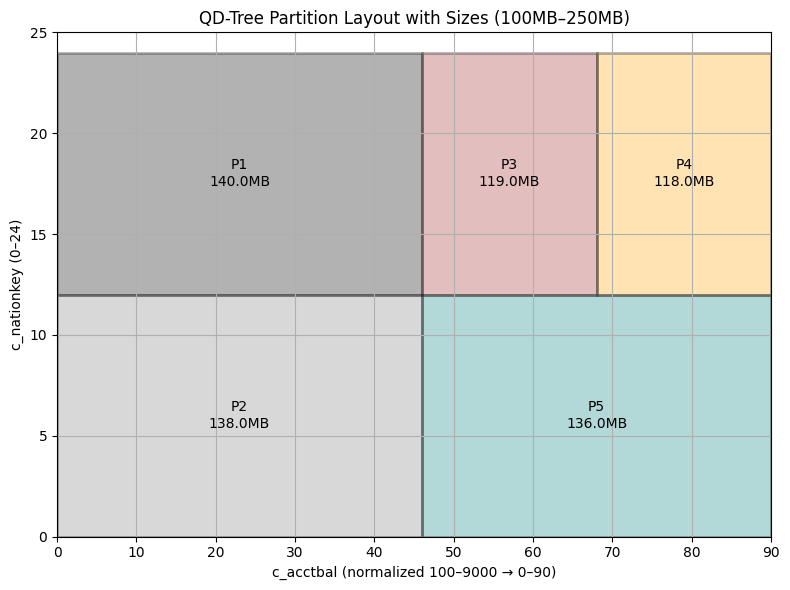

In [16]:
# -----------------------------
# Step 3: Visualize with Size Labels
# -----------------------------
def plot_qd_tree_layout(partition_info):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Define approximate layout (based on prior decision)
    layout = [
        {'id': 'P1', 'x': 0, 'y': 12, 'width': 46, 'height': 12, 'color': 'black'},
        {'id': 'P2', 'x': 0, 'y': 0,  'width': 46, 'height': 12, 'color': 'gray'},
        {'id': 'P3', 'x': 46, 'y': 12, 'width': 22, 'height': 12, 'color': 'brown'},
        {'id': 'P4', 'x': 68, 'y': 12, 'width': 22, 'height': 12, 'color': 'orange'},
        {'id': 'P5', 'x': 46, 'y': 0,  'width': 44, 'height': 12, 'color': 'teal'}
    ]

    for p in layout:
        size_label = partition_info[partition_info['Partition'] == p['id']]['Size_MB'].values[0]
        rect = patches.Rectangle(
            (p['x'], p['y']), p['width'], p['height'],
            linewidth=2, edgecolor='black', facecolor=p['color'], alpha=0.3
        )
        ax.add_patch(rect)
        ax.text(p['x'] + p['width'] / 2, p['y'] + p['height'] / 2,
                f"{p['id']}\n{size_label}MB", fontsize=10, ha='center', va='center', color='black')

    ax.set_xlim(0, 90)
    ax.set_ylim(0, 25)
    ax.set_xlabel("c_acctbal (normalized 100–9000 → 0–90)")
    ax.set_ylabel("c_nationkey (0–24)")
    ax.set_title("QD-Tree Partition Layout with Sizes (100MB–250MB)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run everything
partition_summary = create_qd_partitions(customer_data)
print(partition_summary)
plot_qd_tree_layout(partition_summary)
